# Derive ffCO2 from the APO observations

In this notebook we estimate ffCO2 from APO observations.

We attempt this twice, first using a timevarying APO:ffCO2 ratio, and then using a constant ratio.

We compare the APO-derived ffCO2 to two ffCO2 models:
- NAEI-EDGAR + NAME
- Carbon Tracker (provided by Ingrid Luijx, Wageningen University & Research)

In [1]:
import os, glob
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs

import apo_plot_info, apo_funcs

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
year = 2015
months = [8, 12] #[mm for mm in range(1, 13)] #
sites = ['WAO']
ocean_sims = ['ECCO', 'Jena', 'NEMO']

# baseline estimates to subtract from the obs
baseline = ['rebs', 'jena']

# get the datetimes for the start and end of each month
months = [months] if type(months)==int else months
start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

# number of rows for figures
nrows = len(months) * len(sites)

# the sites and the site names to use when plotting
sites = {site: code for site, code in apo_plot_info.sitecodes.items() if site in sites}

# a date string to use for figure filenames 
date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}{str(months[0]).zfill(2)}-{str(months[-1]).zfill(2)}' if len(months)>2 else \
           f'{year}{str(months[0]).zfill(2)}-{year}{str(months[1]).zfill(2)}' if len(months)==2 else None
print(date_str)

201508-201512


## Calculate APO timeseries

### Get the component timeseries data

We import the timeseries for the APO components.\
The forward models are pre-run in Timeseries/Timeseries_split.py.

In [12]:
ts_data_year = apo_funcs.get_timeseries(sites=sites.keys(), year=year, sources=['ff', 'ocean', 'bc'])
ts_data_all = {site: {month: ts_site.sel(time=slice(start, end_dates[month]))
                      for month, start in start_dates.items()}
               for site, ts_site in ts_data_year.items()}

Finding timeseries for WAO
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']

Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo', 'apo_bc', 'co2_bc', 'o2_bc', 'apo_adjusted_bc']
---------------------------



### Get the Carbon Tracker data

Here we get the Carbon Tracker model. 

The model includes different components: background, ff, bio, ocean, & fires.\
We extract the ff model, and reformat the datetimes to use as a coordinate.

In [4]:
file_type = 'times'
# find the file
ctrack_file_path = os.path.join('/user', 'work', 'vf20487', 'Data', 'CTE2022')
ctrack_file_name = glob.glob(os.path.join(ctrack_file_path, f'co2_wao*{file_type}.nc'))[0]
print(f'carbon tracker file: {ctrack_file_name}')

# open the file and get the model
carbontrack_data = name.open_ds(ctrack_file_name)

if file_type=='times':
        # get the timesteps to use as a coordinate
        carbontrack_data['start_time'] = [datetime(year=time[0],
                                                   month=time[1],
                                                   day=time[2],
                                                   hour=time[3],
                                                   minute=time[4],
                                                   second=time[5])
                                          for time in carbontrack_data.time_components.values]
# get just the model from the CTE dataset
carbontrack_ts = xr.DataArray(data=carbontrack_data['modelsamplesensemble'].values,
                              coords={'time': carbontrack_data.start_time.values,
                                      'nmembers': carbontrack_data.nmembers})

# extract the fossil fuel model
nmembers = {'background': 0, 'fossil': 1, 'biosphere': 2, 'ocean': 3, 'fires': 4}
carbontrack_ff = carbontrack_ts.sel(nmembers=nmembers['fossil'])*1e6

# slice it into months and subtract a minimum as it seems to have an offset
carbontrack_ff = {month: carbontrack_ff.sel(time=slice(start, end_dates[month]))
                  for month, start in start_dates.items()}
carbontrack_ff = {month: ctrack_month - ctrack_month.min()
                  for month, ctrack_month in carbontrack_ff.items()}


carbon tracker file: /user/work/vf20487/Data/CTE2022/co2_wao_surface-insitu_13_alltimes.nc


### Fill in missing dates

The original Carbon Tracker model sent to us only had dates for which there are observations. When plotting this adds weird straight lines to join points at the edge of gaps.

To fix this first we reindex to add the missing dates, setting those values to NaN.

When we've done this it adds lots of gaps in the data where there are just 1 or 2 missing dates. \
To prevent the model looking too gappy, we find the times where there are just 1 or 2 NaN values and forward fill these.

The new model includes the missing datetimes, but I've left this is as it could be useful.

In [5]:
if file_type=='valid':
    # this is the old model which had missing datetimes
    # reindex to match the NAME model and fill in missing dates with NaNs
    carbontrack_ff = {month: ctrack_month.reindex({'time':ts_data_all[list(sites.keys())[0]][month].time}, fill_value=np.nan)
                    for month, ctrack_month in carbontrack_ff.items()}

    # find dates where there are just 1 or 2 missing dates and forward fill
    carbontrack_ff_filled = {month: xr.zeros_like(carbontrack_month)
                            for month, carbontrack_month in carbontrack_ff.items()}
    for month, carbontrack_month in carbontrack_ff.items():
        for cc, carb in enumerate(carbontrack_month):
            carbontrack_ff_filled[month][cc] = carb if cc in [0, len(carbontrack_month.time)-1] else \
                                               carbontrack_ff_filled[month][cc-1] if np.isnan(carb) and any([not np.isnan(carbontrack_month[cc+1]), not np.isnan(carbontrack_month[cc-1])]) else \
                                               carb
else:
    # the new model is filled in for the previously missing datetimes
    for month, c_month in carbontrack_ff.items():
        carbontrack_ff[month]['time'] = ts_data_all[list(sites.keys())[0]][month].time
    carbontrack_ff_filled = {month: c_month for month, c_month in carbontrack_ff.items()}

## Get the obs

- Get the observations for the months specified
- For each month we also import the observations from the month before so that we can test using a rolling average to subtract a baseline

In [6]:
apo_obs_year = get_obs(
                    sites=list(sites.keys()),
                    species='APO',
                    start_date=f'{year}-01-01',
                    end_date=f'{year+1}-01-01'
                    )
apo_obs = {month: {site: [apo_site[0].sel(time=slice(start_date, end_dates[month]))]
                  for site, apo_site in apo_obs_year.items()}
           for month, start_date in start_dates.items()}

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20230213.nc
... slicing from 2015-01-01 00:00:00 to 2015-12-31 23:59:59.999999999


## Plot the APO

Plot the APO observations and the Jena CarboScope baseline


In [7]:
site = 'WAO'
for month, apo_month in apo_obs.items():
  fig = go.Figure()

  fig.add_trace(go.Scatter(
    x = apo_month[site][0].time,
    y = apo_month[site][0].mf,
    name = 'observations',
    line = dict(color=apo_plot_info.colors['obs'])
  ))

  fig.add_trace(go.Scatter(
    x = ts_data_all[site][month].time,
    y = ts_data_all[site][month].apo_adjusted_bc,
    name = 'Jena Carboscope baseline',
    line = dict(color='grey')
  ))

  fig.update_layout(yaxis_title = r'APO, per meg', margin={'l': 80, 'r': 80, 't': 10, 'b': 10})

  fig.show()

## Subtract the baseline

In [11]:
site = list(sites.keys())[0]

if 'rebs' in [bb.lower() for bb in baseline]:
    obs_baseline_file = glob.glob(os.path.join('/user', 'work', 'vf20487', 'Data', f'WAO*{year}*baseline*txt'))[0]
    print(f'REBS obs baseline file: {obs_baseline_file}')

    # read in the data
    obs_baseline_yr = pd.read_csv(obs_baseline_file, delimiter='\t')
    # convert the dates to datetimes
    obs_baseline_yr['time'] = pd.to_datetime(obs_baseline_yr['date'], format='%d/%m/%Y %H:%M')
    obs_baseline_yr = obs_baseline_yr.set_index('time').to_xarray()

    apo_obs_bkgsub = apo_obs_year[site][0].mf - obs_baseline_yr['Stiff baseline - small gaps interpolated']
    apo_obs_bkgsub = {'rebs': {month: apo_obs_bkgsub.sel(time=slice(start_date, end_dates[month]))
                               for month, start_date in start_dates.items()}
                     }

if 'jena' in [bb.lower() for bb in baseline]:
    apo_obs_bkgsub['jena'] = {month: apo_month[site][0].mf - ts_data_all[site][month].apo_adjusted_bc
                              for month, apo_month in apo_obs.items()}

REBS obs baseline file: /user/work/vf20487/Data/WAO_2015_baseline.txt


Saving to /user/work/vf20487/Figures/APO_timeseries/APO_baselines_WAO_2015.png


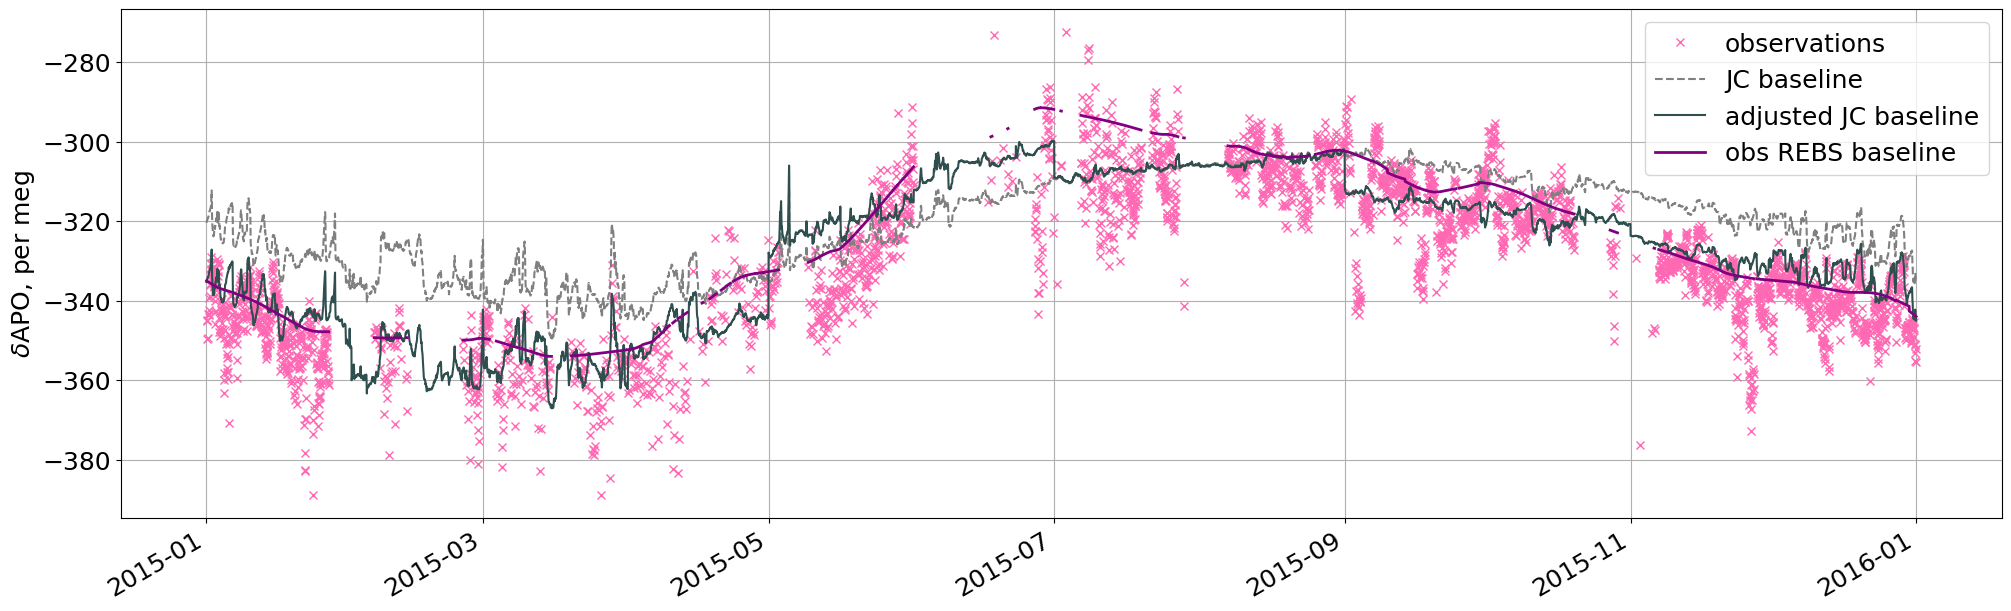

In [31]:
sites_plot = [site for site in sites.keys() if len(apo_obs_year[site])>0]
fontsize = 18

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6), constrained_layout=True, sharex=True)

apo_obs_year[site][0].mf.plot(ax=ax, color='hotpink', ls='none', marker='x', label='observations')
ts_data_year[site].apo_bc.plot(ax=ax, color='grey', ls='--', label='JC baseline')
ts_data_year[site].apo_adjusted_bc.plot(ax=ax, color='darkslategrey', label='adjusted JC baseline')
obs_baseline_yr['Stiff baseline - small gaps interpolated'].plot(ax=ax, color='purple', ls='-', lw=2, label='obs REBS baseline')
# model_rebs_baseline.nemo.plot(ax=ax, color='forestgreen', ls='--', label='model REBS baseline')

legend = ax.legend(bbox_to_anchor=(1, 1.04), loc='upper left', fontsize=fontsize)
legend = ax.legend(loc='best', fontsize=fontsize)
grid = ax.grid()

ticks = ax.tick_params(labelsize=fontsize)
xlabel = ax.set_xlabel('')
ylabel = ax.set_ylabel(r'$\delta$APO, per meg', fontsize=fontsize)

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'APO_baselines_{"-".join(sites)}_{year}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

### Show the baseline subtracted APO

In [9]:
ls = ['solid', 'dash']
colors = [apo_plot_info.colors['obs'], 'purple']
for month in months:
  fig = go.Figure()

  [fig.add_trace(go.Scatter(
     x = apo_base[month].time,
     y = apo_base[month],
     name = f'observations - {base} bkg',
     line = dict(color=colors[bb])
     ))
  for bb, (base, apo_base) in enumerate(apo_obs_bkgsub.items())]

  fig.update_layout(yaxis_title = r'APO, per meg', margin={'l': 80, 'r': 80, 't': 10, 'b': 10})

  fig.show()

## Get the weighted oxidative ratios

We use APO:ffCO2 ratios weighted by the footprint.\
These are calculated in ffCO2/weighted_oxidative_ratio_timeseries.ipynb and we import the timeseries here.

In [10]:
# find the ratio timeseries file
ox_ratio_file = glob.glob(os.path.join('/user','work','vf20487', 'Timeseries', 'OxidativeRatio', f'WeightedAPORatio-gridfed-ukghg_timeseries_{year}.nc'))
ox_ratio_data = name.open_ds(ox_ratio_file[0])

## Calculate the ffCO2

Here we multiply the background subtracted APO obs by the APO:ffCO2 ratio to estimate ffCO2.

We use two methods, first using the timevarying ratio, and then using a constant ratio.

In [23]:
ffco2 = {'varying_ratio': {baseline: {month: ox_ratio_data.apo_ratio.sel(time=slice(start_dates[month], end_dates[month])) * obs_month_base
                                      for month, obs_month_base in obs_base.items()}
                           for baseline, obs_base in apo_obs_bkgsub.items()},
         'constant_ratio': {baseline: {month: -0.3 * obs_month_base
                                       for month, obs_month_base in obs_base.items()}
                            for baseline, obs_base in apo_obs_bkgsub.items()}
        }


### Plot the ffCO2

Here we plot:

- the APO obs-derived ffCO2 with Jena Carboscope background subtraction,
- the APO obs-derived ffCO2 with REBS background subtraction,
- the NAEI-EDGAR-NAME direct ffCO2 model,
- the CTE2022 direct ffCO2 model.

Saving to /user/work/vf20487/Figures/Timeseries/ffCO2/ffCO2_APOobs_WAO_201508-201512.png


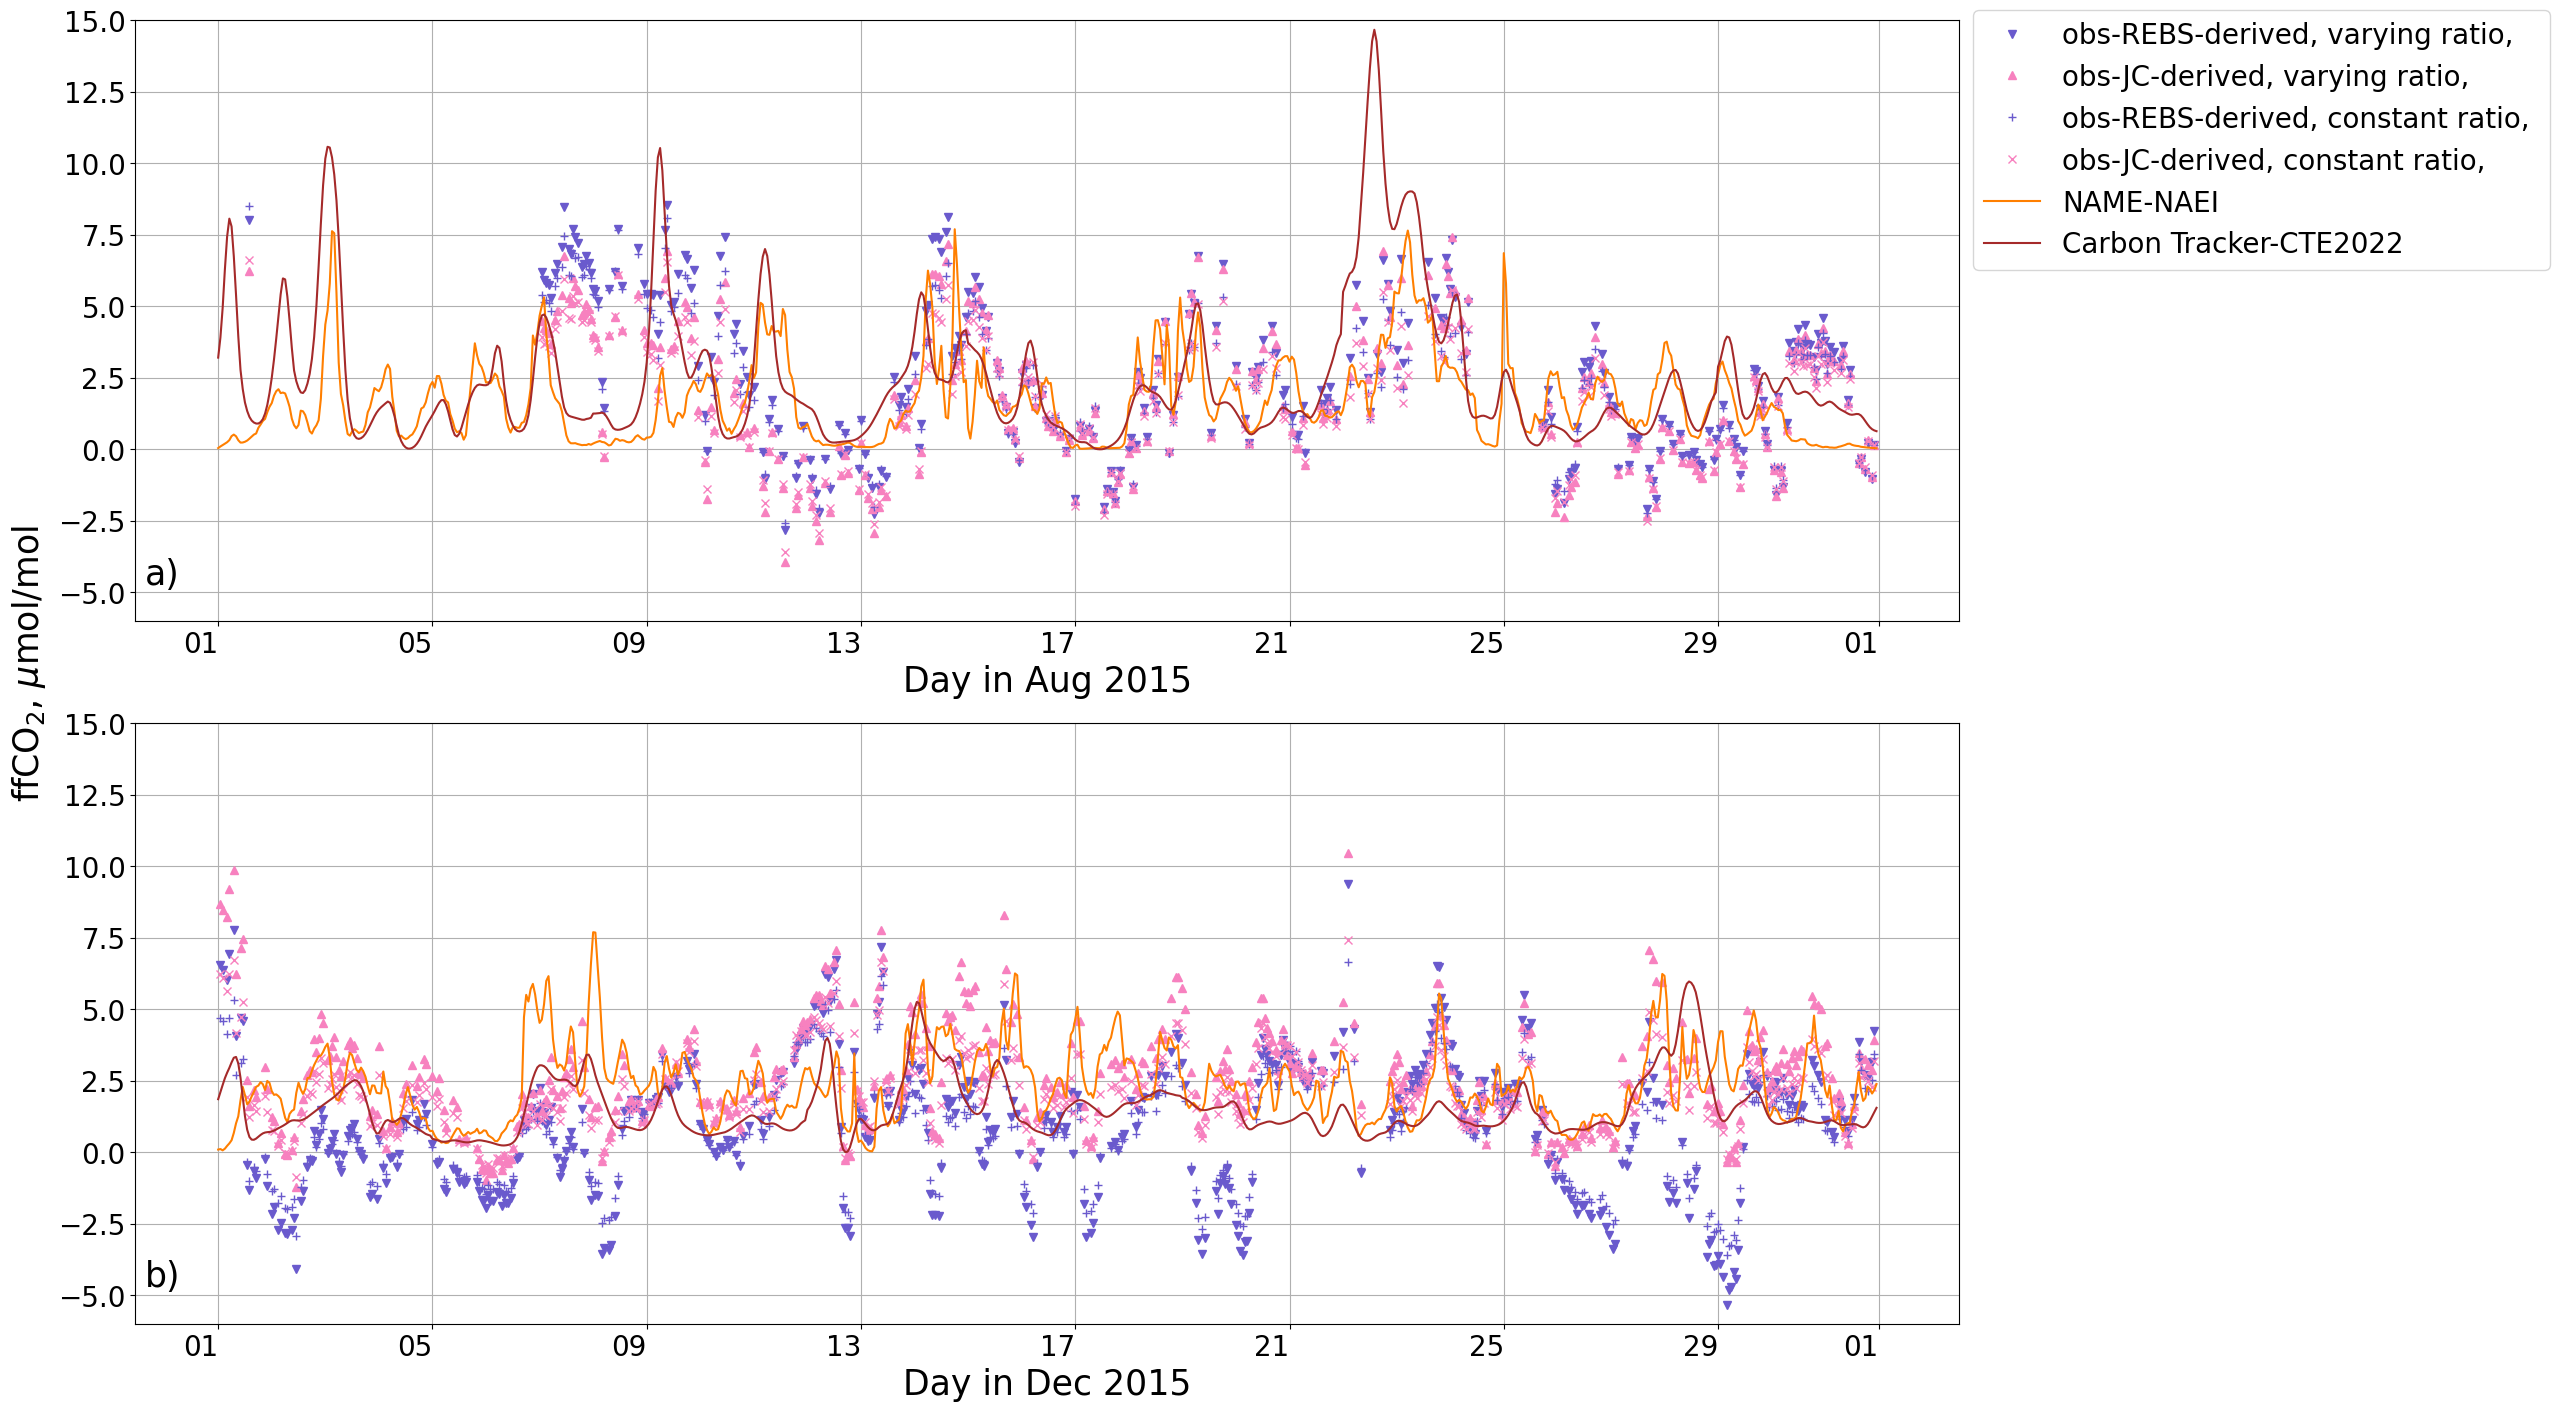

In [26]:
# plotting information
info = {'varying_ratio': {'color': {'jena': apo_plot_info.colors['obs'],
                                    'rebs': 'slateblue'},
                          'marker': {'jena': '^',
                                     'rebs': 'v'}},
        'constant_ratio': {'color': {'jena': apo_plot_info.colors['obs'],
                                     'rebs': 'slateblue'},
                           'marker': {'jena': 'x',
                                      'rebs': '+'}}}

fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, 7*nrows), constrained_layout=True)

# plot the obs-derived ffCO2
obs_plots = {ratio: {baseline: {month: ffco2_month_base.plot(ax=axes[mm], color=info[ratio]['color'][baseline],
                                                             marker=info[ratio]['marker'][baseline],
                                                             ls='none',
                                                             label=f'obs-{apo_plot_info.baseline_names[baseline]}-derived, {" ".join(ratio.split("_"))}, ')
                                for mm, (month, ffco2_month_base) in enumerate(ffco2_base.items())}
                     for baseline, ffco2_base in ffco2_ratio.items()}
             for ratio, ffco2_ratio in ffco2.items()} 
# plot the NAEI direct ffCO2 model
naei_plot = {month: ts_month.co2_ff.plot(ax=axes[mm], color=apo_plot_info.colors['ff'], label='NAME-NAEI')
             for mm, (month, ts_month) in enumerate(ts_data_all[site].items())}
# plot the CTE direct model
carbontracker_plot = {month: ts_month.plot(ax=axes[mm], color='brown', label='Carbon Tracker-CTE2022')
                      for mm, (month, ts_month) in enumerate(carbontrack_ff_filled.items())}

grid = [ax.grid() for ax in axes]
titles = [ax.set_title('') for ax in axes]

# format the tick labels
if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

# add a legend outside the axis
legend = axes[0].legend(bbox_to_anchor=(1, 1.04), loc='upper left', fontsize=20)

# format the axis labels
xlabels = [ax.set_xlabel('') for ax in axes]
xlabels = [axes[mm].set_xlabel(f'Day in {apo_plot_info.month_names[month]} {year}', fontsize=25)
           for mm, month in enumerate(months)]
ylabels = [ax.set_ylabel('') for ax in axes]
ylabel = fig.text(-0.01, 0.53, r'ffCO$_2$, $\mu$mol/mol', va='center', ha='center', rotation='vertical', fontsize=25)

# set the y limits to be consistent across all axes
ylims = [ax.set_ylim(-6, 15) for ax in axes]

# add labels for the panel number
panel_labels = [ax.text(0.005, 0.05, f'{chr(97+aa)})', transform=ax.transAxes, va='bottom', fontsize=25)
                for aa, ax in enumerate(axes.flat)]

### save the figure
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'ffCO2', 
                            f'ffCO2_APOobs_{site}_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Calculate the correlation

Calculate the Pearson correlation coefficient and RMSE between the obs-derived ffCO2 and dirctly modelled ffCO2 for both NAEI-EDGAR-NAME and CTE2022.

In [15]:
rmse = {ratio: {baseline: {month: (((ts_data_all[site][month].co2_ff - ffco2_month)**2).mean().values)**0.5
                           for month, ffco2_month in ffco2_baseline.items()}
                for baseline, ffco2_baseline in ffco2_ratio.items()}
        for ratio, ffco2_ratio in ffco2.items()}
correlations = {ratio: {baseline: {month: float(xr.corr(ffco2_month, ts_data_all[site][month].co2_ff))**2
                                   for month, ffco2_month in ffco2_baseline.items()}
                        for baseline, ffco2_baseline in ffco2_ratio.items()}
                for ratio, ffco2_ratio in ffco2.items()}

rmse_ctrack = {ratio: {baseline: {month: (((carbontrack_ff[month] - ffco2_month)**2).mean().values)**0.5
                                  for month, ffco2_month in ffco2_baseline.items()}
                       for baseline, ffco2_baseline in ffco2_ratio.items()}
               for ratio, ffco2_ratio in ffco2.items()}
correlations_ctrack = {ratio: {baseline: {month: float(xr.corr(ffco2_month, carbontrack_ff[month]))**2
                                          for month, ffco2_month in ffco2_baseline.items()}
                               for baseline, ffco2_baseline in ffco2_ratio.items()}
                       for ratio, ffco2_ratio in ffco2.items()}

# print('RMSE')
# print_rmse = [[print(f'{ratio}, {apo_plot_info.month_names[month]} rmse:    {rmse_month}')
#                for month, rmse_month in rmse_ratio.items()]
#               for ratio, rmse_ratio in rmse.items()] 
# print('\nCorrelation')
# print_corr = [[print(f'{ratio}, {apo_plot_info.month_names[month]} correlation:    {corr_month}')
#                for month, corr_month in corr_ratio.items()]
#               for ratio, corr_ratio in correlations.items()]

# print('\nRMSE, Carbon Tracker')
# print_rmse = [[print(f'{ratio}, {apo_plot_info.month_names[month]} rmse:    {rmse_month}')
#                for month, rmse_month in rmse_ratio.items()]
#               for ratio, rmse_ratio in rmse_ctrack.items()] 
# print('\nCorrelation, Carbon Tracker')
# print_corr = [[print(f'{ratio}, {apo_plot_info.month_names[month]} correlation:    {corr_month}')
#                for month, corr_month in corr_ratio.items()]
#               for ratio, corr_ratio in correlations_ctrack.items()]

### Ploe the correlations

Saving to /user/work/vf20487/Figures/Timeseries/ffCO2/ffCO2_correlations_WAO_2015.png


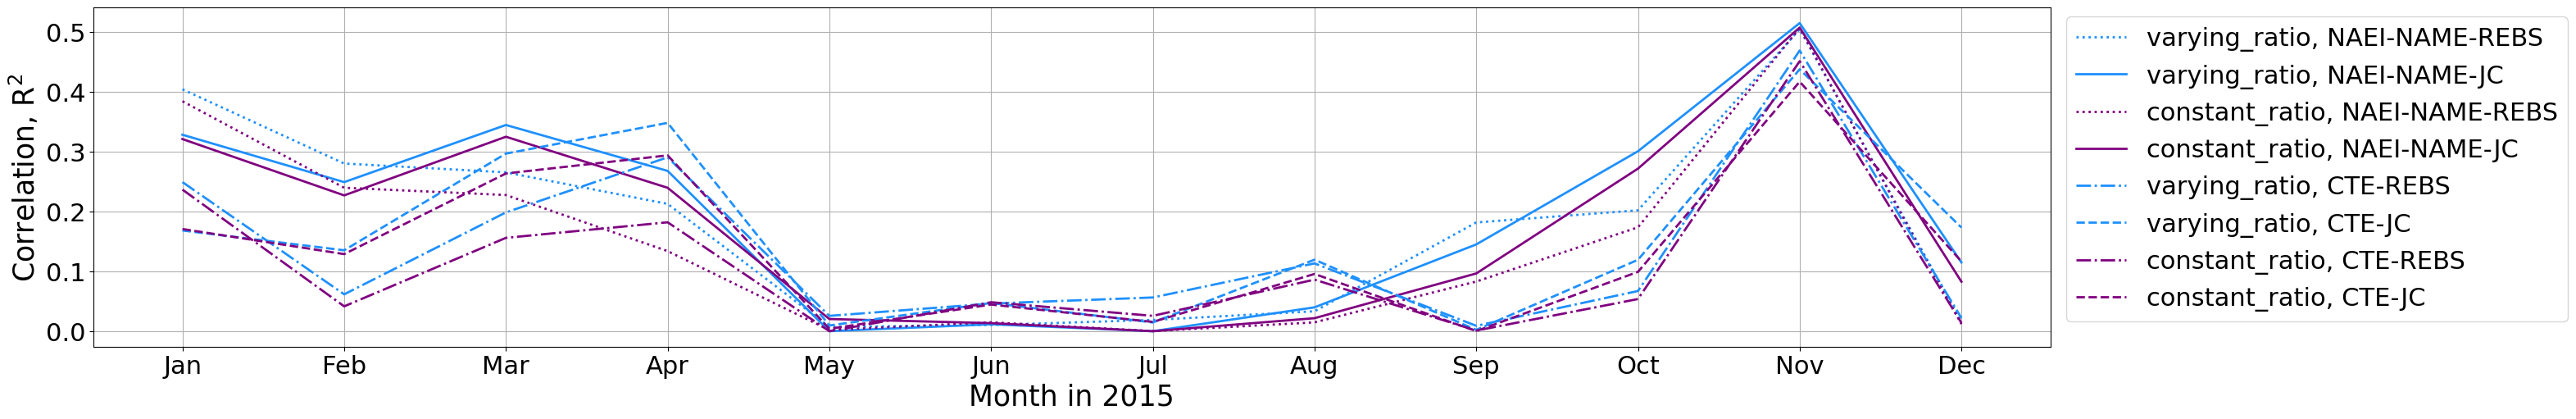

In [16]:
colors = {'varying_ratio': 'dodgerblue', 'constant_ratio': 'purple'}
ls = {'rebs': {'NAEI-NAME': ':', 'CTE': '-.'}, 'jena': {'NAEI-NAME': '-', 'CTE': '--'}}
marker = {'rebs': {'NAEI-NAME': 'none', 'CTE': 'none'}, 'jena': {'NAEI-NAME': 'none', 'CTE': 'none'}}

if len(months)>=12:
    sites_plot = ['WAO']
    sites_plot = [site for site in sites_plot if site in sites]

    fig, axes = plt.subplots(nrows=1*len(sites_plot), ncols=1, figsize=(25, 5*len(sites_plot)), sharex=True, constrained_layout=True)
    axes = [axes] if len(sites_plot)==1 else axes

    for model, corr_model in {'NAEI-NAME': correlations, 'CTE': correlations_ctrack}.items():
        # plot the correlations
        corr_plot = [[[axes[ss].plot(apo_plot_info.month_names.values(), corr_base.values(),
                                    color=colors[ratio],
                                    label=f'{ratio}, {model}-{apo_plot_info.baseline_names[baseline]}',
                                    ls=ls[baseline][model],
                                    marker=marker[baseline][model],
                                    lw=2)
                        for baseline, corr_base in corr_ratio.items()]
                      for ratio, corr_ratio in corr_model.items()]
                     for ss, site in enumerate(sites_plot)]

    ticks = [ax.tick_params(labelsize=22) for ax in axes]   # format the tick labels
    legend = fig.legend(bbox_to_anchor=(1, 1), fontsize=22, loc='upper left') # add a legend outside of axis
    grid = [ax.grid() for ax in axes]

    # format the axis labels
    xlabels = [ax.set_xlabel('') for ax in axes]
    xlabel = axes[-1].set_xlabel(f'Month in {year}', fontsize=25)
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
               for ll, label in enumerate([r'Correlation, R$^2$'])] #, 'RMSE, per meg'])]
    # ax_labels = [ax.text(0.005, 0.015, f'{chr(97+aa)})', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

    ### save the figure
    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'ffCO2',
                            f'ffCO2_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)